# EVAL Problem 1
In this EVAL problem, we will study the actual request lengths that are now unknowns that depend on the interaction between the workload created by the client and the server operating on the hardware at hand.

In [99]:
# IMPORTS
from PIL import Image
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

------
a) Alright folks, first off, congratulations on implementing your first REAL server that's doing an actual job: Image Processing.
Welcome to the fun part: You get to test out and see what happens to your image after a few manipulations.

For this, you will need to add a single line right before you are about to RETRIEVE the image. When retrieving, right before you send your image back to the client, you can save your manipulated image to see what has happened to it. You have access to the following function:

**`uint8_t saveBMP(const char* filename, const struct image* img)`**

This function is defined in your imglib.c file and you will be able to call this directly in your server_img.c

To save the image, call this right before RETRIEVING and you'll be able to save the manipulated image. Save it and attach this image to your EVAL document and describe what has happened to the original image from your observation as well as the client requests, while running the following parameters:

run: `./build/server_img -q 100 2222 & ./client -a 30 -I images/ -n 5 2222` (this works provided that your server object file is in
the build while the client that we provide to you is outside of the build as requested :) )

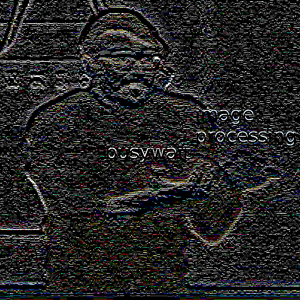

In [100]:
img = Image.open('./partA/image.png')
img_resized = img.resize((300, 300))  
display(img_resized)

It looks like the processed image has undergone edge detection. The original image is a clear, colored image showing details and texts. The processed image emphasizes outlines and edges, likely highlighting boundaries and shapes in a high-contrast manner. It focuses on the contours of objects, while colors and textures are minimized.

Based on the client requests and responses, the client registered an image and requested horizontal edge detection on the image. Sharpening was then applied twice to the same image and finally the processed image was retrieved from the server.



------
b) For this part, we are interested in the distribution of request lengths as measured by the server on your machine.

Here, it is immediately important to remember that your results might wildly vary when you compare them with those obtained by
your colleagues, because you will be running your code on very different machines. The only good point is that now you can compete with your friends about who has the best machine!

To carry out these experiments, run the following command TWO times. 

The first time, run: `./build/server_img -q 100 2222 & .//client -a 30 -I images_small/ -n 1000 2222` (NOTE: if your local machine
(in case you are not using the SCC) is too weak—#noshame—and starts rejecting requests with the parameters above, you can reduce the arrival rate of requests sent by the client, but keep the same total number -n 1000).

In the images_small only keep the two smallest images, i.e. test1.bmp and test2.bmp. Collect the output of the server and client, and set them aside.

Next, run:

`./build/server_img -q 100 2222 & ./client -a 30 -I images_all/ -n 1000 2222`

In the images_all folder, keep all the images in the dataset. Once again, Collect the output of the server and client, and set them aside.

Post process the outputs from RUN1 and RUN2 and for each run, produce a plot of the CDF (with average and 99% tail latency, as we did in HW5) of the amount of time taken by EACH image operation, but exclude IMG_RETRIEVE—we do not trust the timing reporting of that one! So you should have 6 plots per run, one per operation for a total of 12 plots. Keep them small enough so that you can fit all of them in a single page, maybe 3 plots per row. Here I strongly encourage you not to generate each plot manually, but rather use some form of scripting.

Now look at the plots, and answer the following: (1) within the same run, what operations are similar in behavior and which ones
behave differently? (2) Within the same run, which ones are the least predictable operations? (3) Across runs, by how much does
the average response time increase for each operation? (4) Across runs, by how much does the 99% tail latency increase for each
operation?

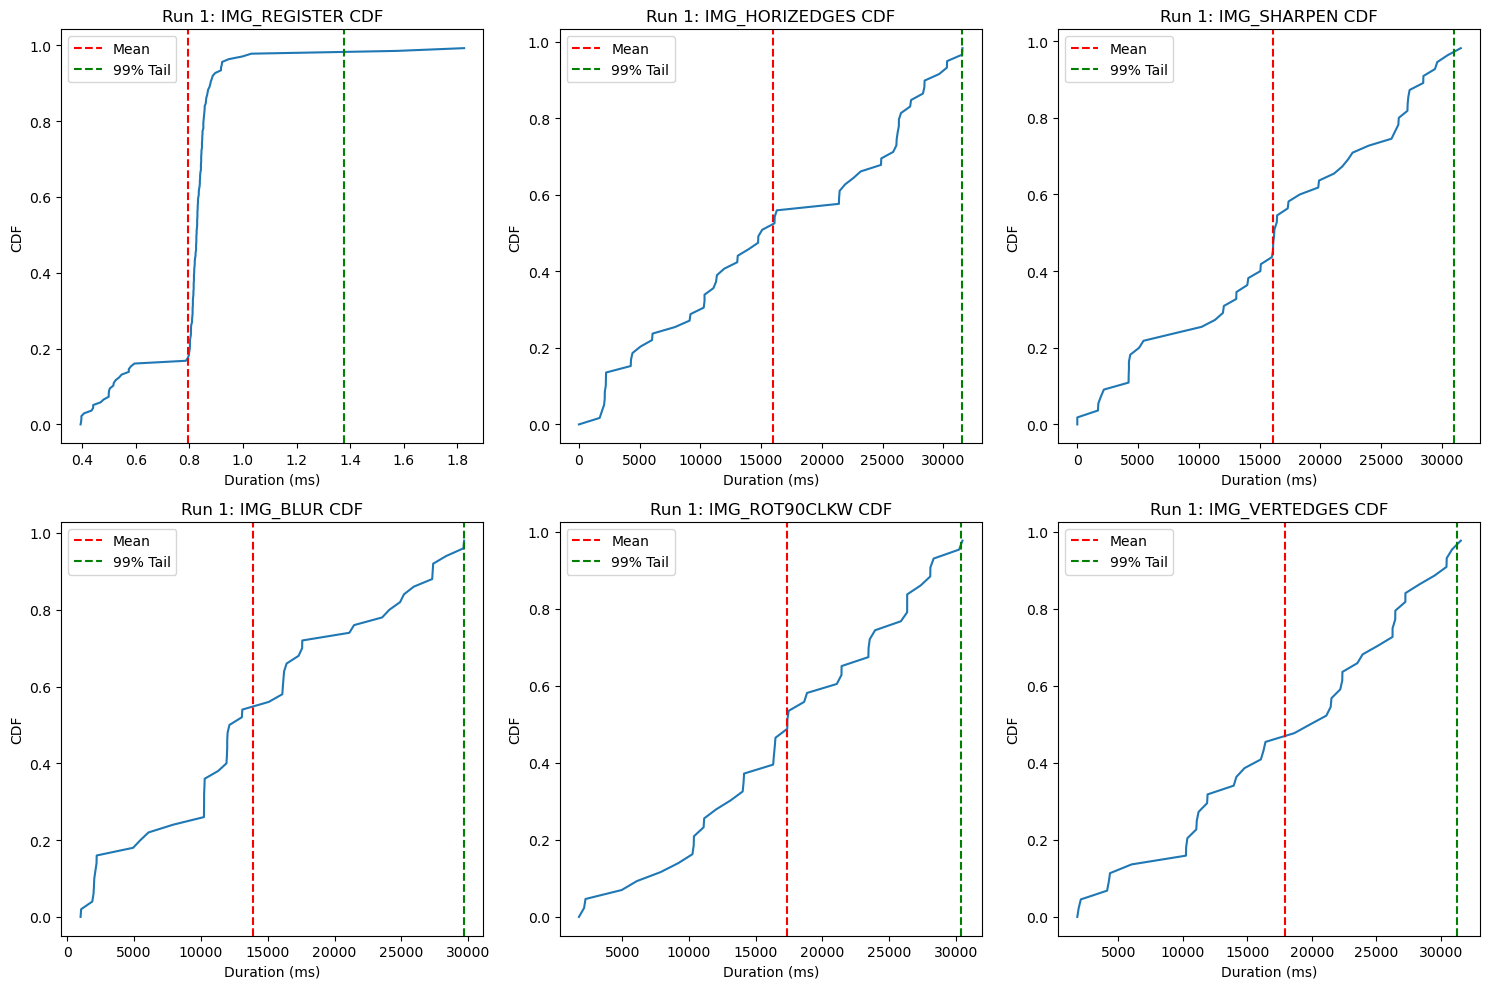

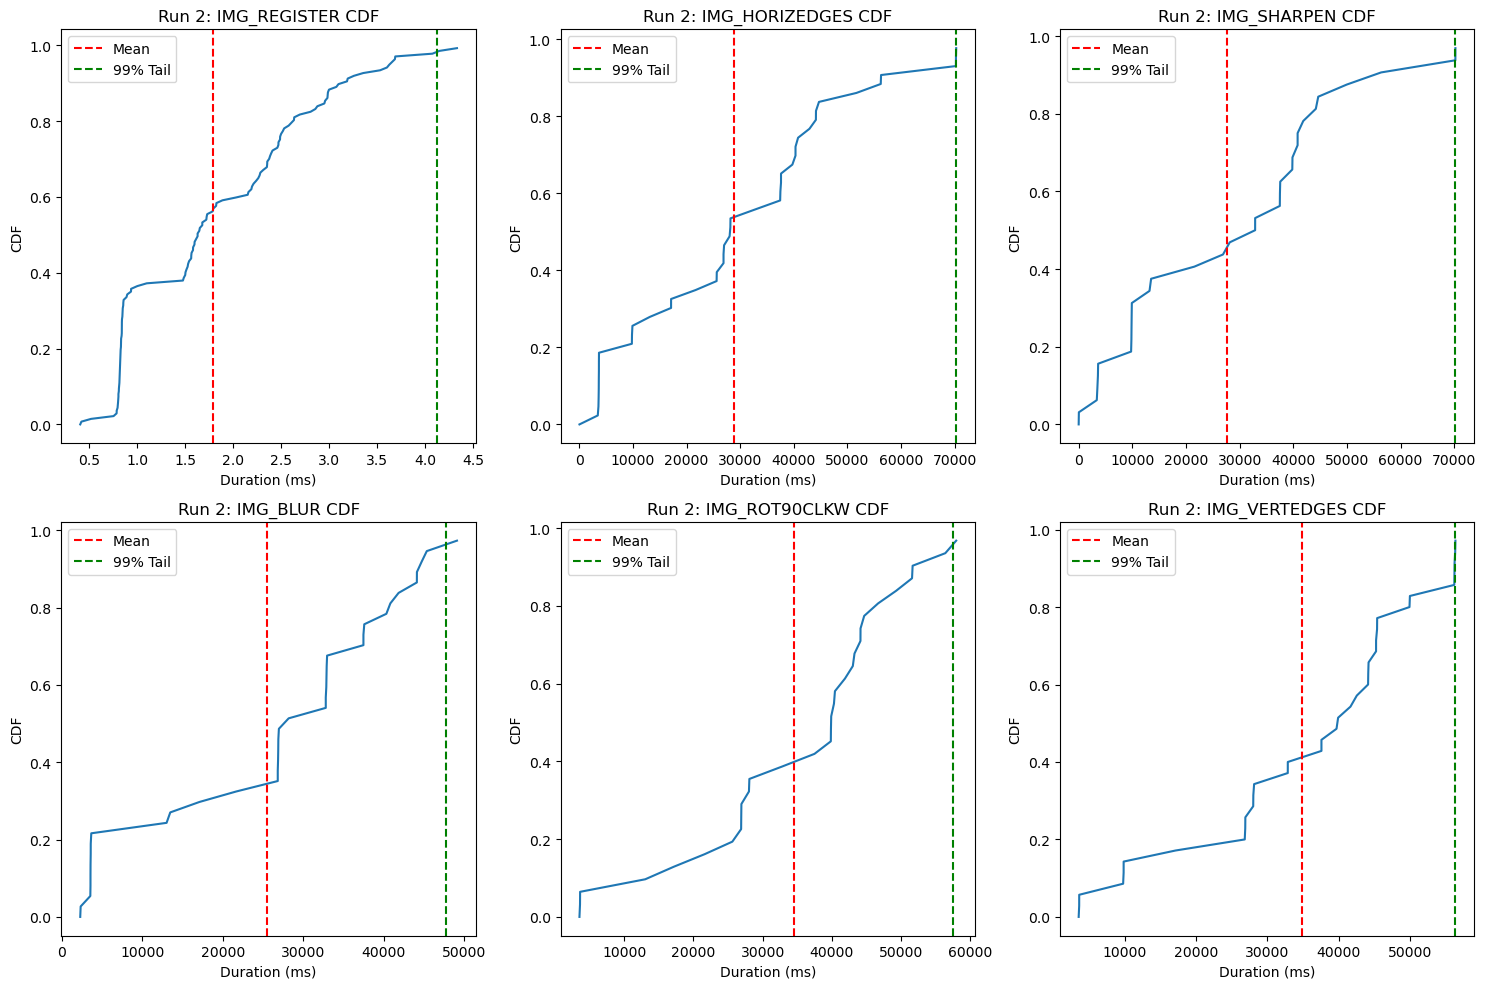

In [101]:
def parse_output(file_path):
	pattern = re.compile(r'T\d+ R\d+:\d+\.\d+,(\w+),\d+,\d+,\d+,\d+\.\d+,\d+\.\d+,\d+\.\d+')
	data = []
	
	with open(file_path, 'r') as file:
		for line in file:
			match = pattern.search(line)
			if match:
				operation = match.group(1)
				if operation != 'IMG_RETRIEVE':
					timestamps = list(map(float, line.split(',')[4:]))
					duration = (timestamps[2] - timestamps[1]) * 1000  # Convert to milliseconds
					data.append((operation, duration))

	return pd.DataFrame(data, columns=['operation', 'duration'])

def plot_cdf(data, operation, ax):
	sorted_data = np.sort(data)
	cdf = np.arange(len(sorted_data)) / len(sorted_data)
	ax.plot(sorted_data, cdf)
	ax.set_title(f'{operation} CDF')
	ax.set_xlabel('Duration (ms)')
	ax.set_ylabel('CDF')
	ax.axvline(np.mean(sorted_data), color='r', linestyle='--', label='Mean')
	ax.axvline(np.percentile(sorted_data, 99), color='g', linestyle='--', label='99% Tail')
	ax.legend()

# Load and parse data
data_run1 = parse_output('./partB/output_small.txt')
data_run2 = parse_output('./partB/output_all.txt')
operations = data_run1['operation'].unique()

# Plot for each operation
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, operation in enumerate(operations):
	ax_run1 = axs[i // 3, i % 3]
	run1_data = data_run1[data_run1['operation'] == operation]['duration']
	plot_cdf(run1_data, f'Run 1: {operation}', ax_run1)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, operation in enumerate(operations):
	ax_run2 = axs[i // 3, i % 3]
	run2_data = data_run2[data_run2['operation'] == operation]['duration']
	plot_cdf(run2_data, f'Run 2: {operation}', ax_run2)
plt.tight_layout()
plt.show()

<u>**Similar & Different Behaviors:**</u>

- **RUN1** : `IMG_HORIZEDGES`, `IMG_SHARPEN`, `IMG_VERTEDGES`, `IMG_BLUR`, and `IMG_ROT90CLKW` show similar response time distributions, with mean response times close to each other and CDFs that gradually approach 1 across similar time ranges. `IMG_REGISTER` behaves differently from the others, with very short durations (under 2ms), making it much faster than all other operations in this run.
- **RUN2** : `IMG_HORIZEDGES`, `IMG_SHARPEN`, `IMG_VERTEDGES`, `IMG_BLUR`, and `IMG_ROT90CLKW` again display similar patterns, though with an increased range in durations compared to Run 1. `IMG_REGISTER` stands out in this run, with significantly shorter durations (up to 4.5ms), in contrast to the other operations.

<u>**Least Predictable:**</u>

In both runs, the least predictable operations are `IMG_HORIZEDGES`, `IMG_SHARPEN`, `IMG_BLUR`, `IMG_ROT90CLKW`, and `IMG_VERTEDGES`. These operations have CDFs that increase gradually, indicating variability and a wider range of response times. `IMG_REGISTER`, on the other hand, shows a steep CDF, suggesting a narrow distribution and consistent performance, making it the most predictable operation in both runs.

<u>**Average Response Time Increase:**</u>

- `IMG_REGISTER`: The average response time increased by a factor of about 2–3 times from Run 1 to Run 2.
- `IMG_HORIZEDGES`, `IMG_SHARPEN`, `IMG_ROT90CLKW`: The average response times for these operations roughly doubled.
- `IMG_BLUR`, `IMG_VERTEDGES`: The average response time increased by a factor of around 1.5–2 times.


<u>**99% Tail Latency Increase:**</u>

- `IMG_REGISTER`: The 99% tail latency increased by about 2–3 times from Run 1 to Run 2.
- `IMG_HORIZEDGES`, `IMG_SHARPEN`, `IMG_ROT90CLKW`: The 99% tail latency increased roughly by a factor of 2.
- `IMG_BLUR`, `IMG_VERTEDGES`: The 99% tail latency increased by a factor of around 1.5–2 times.


------
c) For this part, no need to run new commands! Yay! Instead, retrieve the output you generated in the previous part. The one for RUN2 in particular.

As you parse the output produced by your server, construct an online estimator for the length of each type of request. In other words, consider each type of image request (e.g., `IMG_ROT90CLKW` vs. `IMG_HORIZEDGES` etc.) as a separate task. Every time you observe an operation of a given type, consider the measured length as a new job length sample. Build an exponentially weighted moving average estimator (EWMA) with parameter $α = 0.7$ for each request type. Use the estimator to predict the length of the next operation of the same type.

So, say you have observed $n$ operations of type `IMG_ROT90CLKW`, you will construct the estimator `C¯(n)IMG ROT90CLKW` for the $(n + 1)^{th}$ operation of the same type.

For each request type, compute the misprediction error as the absolute value of the difference between your prediction and the observed $n^{th}$ job length. Take an average of that error and reason on how good your predictions are for each image operation (i.e.,
for each task).

In [102]:
def parse_output(file_path):
	pattern = re.compile(r'T\d+ R\d+:\d+\.\d+,(\w+),\d+,\d+,\d+,\d+\.\d+,\d+\.\d+,\d+\.\d+')
	data = []
	
	with open(file_path, 'r') as file:
		for line in file:
			match = pattern.search(line)
			if match:
				operation = match.group(1)
				if operation != 'IMG_RETRIEVE':
					timestamps = list(map(float, line.split(',')[4:]))
					duration = (timestamps[2] - timestamps[1]) * 1000 
					data.append((operation, duration))
	
	return pd.DataFrame(data, columns=['operation', 'duration'])

def compute_ewma(data, alpha=0.7):
	predictions = {}
	errors = {}
	
	for operation in data['operation'].unique():
		op_data = data[data['operation'] == operation]['duration'].tolist()
		if not op_data:
			continue
		
		ewma = op_data[0]
		total_error = 0
		for n in range(1, len(op_data)):
			prediction = ewma
			actual = op_data[n]
			error = abs(prediction - actual)
			total_error += error
			
			ewma = alpha * actual + (1 - alpha) * ewma
		
		average_error = total_error / (len(op_data) - 1)
		predictions[operation] = ewma
		errors[operation] = average_error
	
	return predictions, errors

data_run2 = parse_output('./partB/output_all.txt')

predictions, average_errors = compute_ewma(data_run2)

for operation in predictions:
	print(f"Operation: {operation}")
	print(f"  Final EWMA Prediction: {predictions[operation]:.2f} ms")
	print(f"  Average Prediction Error: {average_errors[operation]:.2f} ms\n")

Operation: IMG_REGISTER
  Final EWMA Prediction: 2.88 ms
  Average Prediction Error: 1.03 ms

Operation: IMG_HORIZEDGES
  Final EWMA Prediction: 69767.91 ms
  Average Prediction Error: 2921.35 ms

Operation: IMG_SHARPEN
  Final EWMA Prediction: 68734.80 ms
  Average Prediction Error: 3369.37 ms

Operation: IMG_BLUR
  Final EWMA Prediction: 47587.39 ms
  Average Prediction Error: 2097.08 ms

Operation: IMG_ROT90CLKW
  Final EWMA Prediction: 56079.88 ms
  Average Prediction Error: 3210.00 ms

Operation: IMG_VERTEDGES
  Final EWMA Prediction: 56332.77 ms
  Average Prediction Error: 2598.22 ms



Given this, it seems that `IMG_REGISTER` is highly predictable with low average errors. The least predictable were operations like `IMG_HORIZEDGES` and `IMG_SHARPEN`. They had higher prediction errors, indicating variability. The general trend was that more computationally intensive operations show greater variability and prediction error.

-----
d)  Okay, here we need to re-run some experiments. First off, set aside the output you produced for RUN2 in part (a). Now, take a look at the Makefile included in the template files and locate the following line: `LDFLAGS = -lm - lpthread -O0`. Focus on the `-O0` (minus capital “o” zero).

First, set that to `-O1`, then run the command make clean (careful! this will remove the entire build folder), and then make again to recompile the server and all the libraries from scratch. Next, rerun the same command you used for RUN2 (the one with all the images) in part (a).

Now, do everything once again with `-O2`. At this point, you should have 3 outputs in total. Post-process those outputs to generate 1 plot per output depicting the CDF (with average and 99% tail latency) of the length of any image operation. In other words, do not differentiate by operation type, but treat all the operations from the same output as if
they were all just generic image processing operations. Thus, you should just produce 3 plots, one for the `-O0` case, one for the `-O1` case, and one for the `-O2` case.

First, try to figure out what the `-O<value>` flag is supposed to do in theory by looking up (or remembering from CS210) what that is. Next, with plotted data at hand, answer the question of whether or not that flag is behaving as it is supposed to.

Optimization Level O0: Mean = 21.52 ms, 99% Tail = 68.14 ms
Optimization Level O1: Mean = 21.48 ms, 99% Tail = 68.11 ms
Optimization Level O2: Mean = 21.45 ms, 99% Tail = 67.94 ms


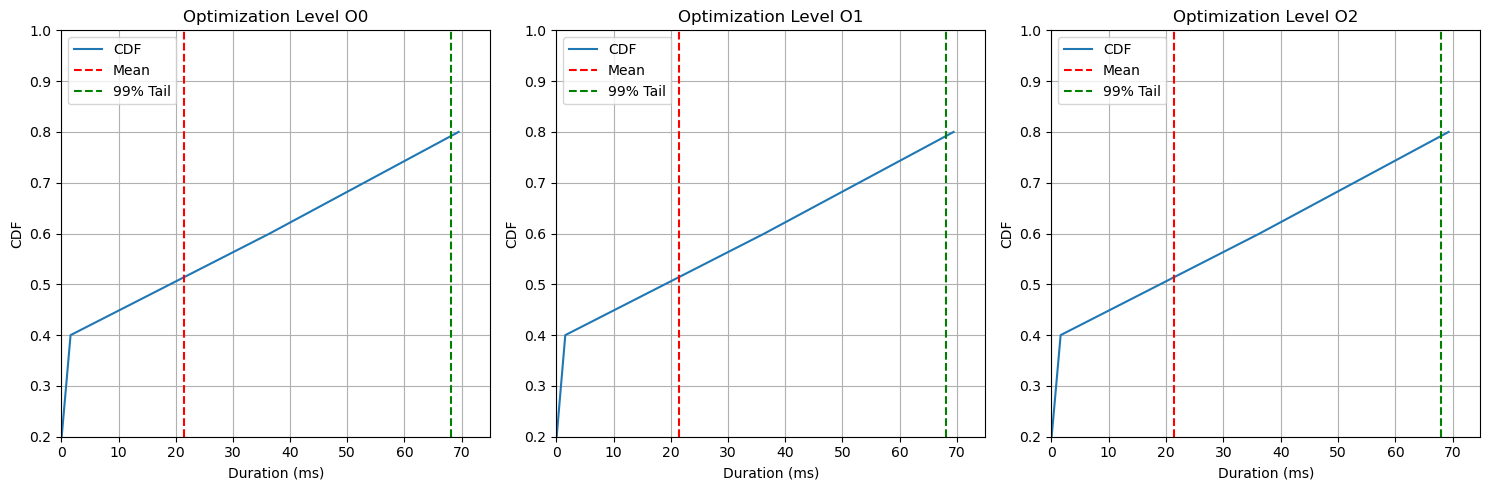

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_output(file_path):
    pattern = re.compile(r'T\d+ R\d+:\d+\.\d+,\w+,\d+,\d+,\d+,\d+\.\d+,\d+\.\d+,\d+\.\d+')
    durations = []
    
    with open(file_path, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                timestamps = list(map(float, line.split(',')[4:]))
                duration = (timestamps[2] - timestamps[1]) * 1000  # Convert to milliseconds
                durations.append(duration)
    
    return durations

def calculate_stats(durations):
    mean_duration = np.mean(durations)
    tail_99 = np.percentile(durations, 99)
    return mean_duration, tail_99

def plot_cdf(durations, title):
    sorted_data = np.sort(durations)
    cdf = np.arange(len(sorted_data)) / len(sorted_data)
    mean_duration, tail_99 = calculate_stats(durations)
    
    plt.plot(sorted_data, cdf, label='CDF')
    plt.axvline(mean_duration, color='r', linestyle='--', label='Mean')
    plt.axvline(tail_99, color='g', linestyle='--', label='99% Tail')
    plt.title(title)
    plt.xlabel('Duration (ms)')
    plt.ylabel('CDF')
    plt.xlim(0, tail_99 * 1.1)  # Zoom in on x-axis
    plt.ylim(0.2, 1)  # Zoom in on y-axis
    plt.legend()
    plt.grid(True)

    # Print mean and 99% tail
    print(f"{title}: Mean = {mean_duration:.2f} ms, 99% Tail = {tail_99:.2f} ms")

# Load and parse data
durations_O0 = parse_output('./partD/outputO0.txt')
durations_O1 = parse_output('./partD/outputO1.txt')
durations_O2 = parse_output('./partD/outputO2.txt')

# Plot CDFs
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_cdf(durations_O0, 'Optimization Level O0')

plt.subplot(1, 3, 2)
plot_cdf(durations_O1, 'Optimization Level O1')

plt.subplot(1, 3, 3)
plot_cdf(durations_O2, 'Optimization Level O2')

plt.tight_layout()
plt.show()

The `-O` flag in compilation specifies different levels of optimization. `-O0` is no optimization, `-O1` is basic optimization, `-O2` is further optimization. 

Analyzing the plotted data and the output, there is a slight decrease in the mean latency from `-O0` to `-O2`. The output shows a decrease from 21.52ms to 21.48ms to 21.45ms. The 99% tail latency also has a slight decrease from `-O0` to `-O2`. The output shows a decrease from 68.14ms to 68.11ms to 67.94ms. 

The optimization flags are working as expected, with minor improvements in both mean and 99% tail latencies. The differences are small, suggesting that the operations might not be heavily optimized further by these flags. Thus, the `-O` flags are behaving as intended, but the impact is minimal, suggesting that the operations may nto eb heavily impacted by these optimizations.